In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_7dim.npz')                  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm', 'ns', 'z', 'lnAs', 'w']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  1400


In [6]:
cosmo_params = np.zeros((len(train_params['omega_b']), 7))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']
cosmo_params[:, 3] = train_params['ns']
cosmo_params[:, 4] = train_params['z']
cosmo_params[:, 5] = train_params['lnAs']
cosmo_params[:, 6] = train_params['w']

[0. 0. 0. 0. 0. 0. 0.]


In [7]:
print(cosmo_params[0])
print(cosmo_params[199])

[ 0.73436741  0.02260329  0.14292352  0.88926376  3.75696926  3.8340243
 -1.48263045]
[ 0.7701644   0.02434453  0.10117941  1.05279485  6.58184417  3.71601144
 -0.67076483]


In [8]:
def camb_cosmo(i):
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100*cosmo_params[i, 0], ombh2=cosmo_params[i, 1], omch2=cosmo_params[i, 2])
    pars.InitPower.set_params(As = np.exp(cosmo_params[i,5])/(10**10), ns=cosmo_params[i,3])
    pars.set_matter_power(redshifts=[cosmo_params[i,4]], kmax=10.0)
    pars.set_dark_energy(w=cosmo_params[i,6], wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=400)
    s8 = np.array(results.get_sigma8())      
    # s8 is the amplitude of matter fluctuations, i.e. in term of the average r.m.s fluctuation in a sphere of 8h^{−1}Mpc
    

    
#     plt.figure(figsize = (10,8))
#     plt.loglog(camb_kh, camb_pk[0], 'r')
#     #plt.plot(, r_array, 'ro')
#     plt.title('Matter Power Spectrum at z=0.0')
#     plt.rc('axes', labelsize=18)
#     plt.rc('axes', titlesize=16)
#     plt.rcParams['xtick.labelsize']=14
#     plt.rcParams['ytick.labelsize']=14
#     plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
#     plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#     #plt.legend(['linear'], loc='lower left', fontsize=14);
#     plt.grid(alpha=0.2)
#     plt.tick_params(top=True,right=True, length=6)
#     plt.show()
    
    return camb_kh, camb_pk[0] 
    
    
cosmo_func = camb_cosmo(0)                                                   #calculates the m.p.s of 1st sample out of 200
#print(cosmo_func[1])
#print(pk[0])

Epoch 1/100
14/14 - 0s - loss: 0.9530 - 332ms/epoch - 24ms/step
Epoch 2/100
14/14 - 0s - loss: 0.9301 - 12ms/epoch - 855us/step
Epoch 3/100
14/14 - 0s - loss: 0.8838 - 18ms/epoch - 1ms/step
Epoch 4/100
14/14 - 0s - loss: 0.8038 - 16ms/epoch - 1ms/step
Epoch 5/100
14/14 - 0s - loss: 0.6943 - 19ms/epoch - 1ms/step
Epoch 6/100
14/14 - 0s - loss: 0.5707 - 16ms/epoch - 1ms/step
Epoch 7/100
14/14 - 0s - loss: 0.4375 - 15ms/epoch - 1ms/step
Epoch 8/100
14/14 - 0s - loss: 0.3219 - 16ms/epoch - 1ms/step
Epoch 9/100
14/14 - 0s - loss: 0.2273 - 15ms/epoch - 1ms/step
Epoch 10/100
14/14 - 0s - loss: 0.1677 - 15ms/epoch - 1ms/step
Epoch 11/100
14/14 - 0s - loss: 0.1301 - 16ms/epoch - 1ms/step
Epoch 12/100
14/14 - 0s - loss: 0.1018 - 15ms/epoch - 1ms/step
Epoch 13/100
14/14 - 0s - loss: 0.0818 - 15ms/epoch - 1ms/step
Epoch 14/100
14/14 - 0s - loss: 0.0636 - 15ms/epoch - 1ms/step
Epoch 15/100
14/14 - 0s - loss: 0.0489 - 16ms/epoch - 1ms/step
Epoch 16/100
14/14 - 0s - loss: 0.0358 - 15ms/epoch - 1ms/st

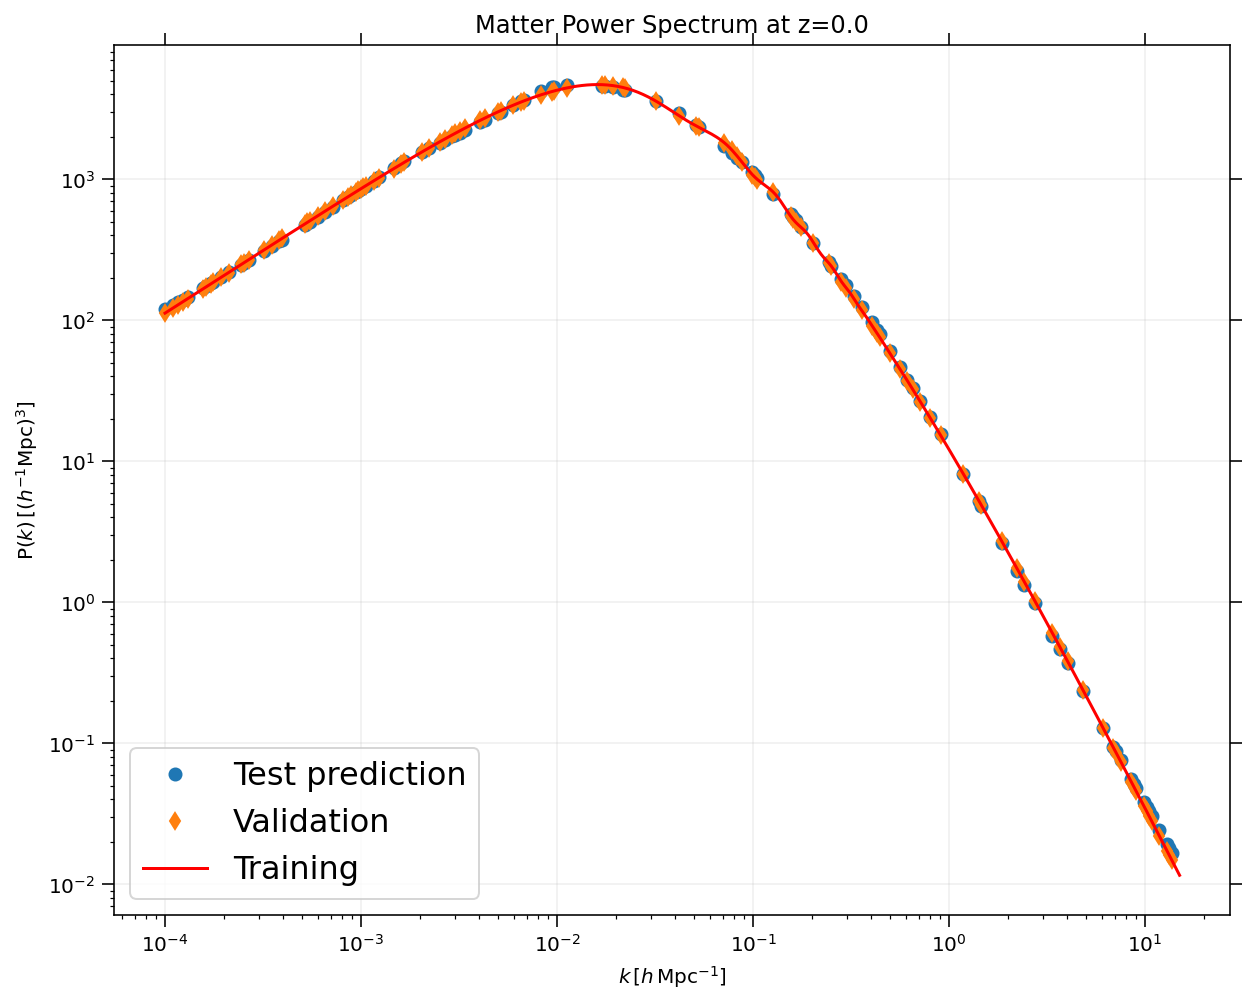

In [9]:
## TESTING (ANN for computing many cosmologies (for n_samples)):

# Generate power spectra:
cosmo_func = camb_cosmo(0)
    
train_k = cosmo_func[0]                                                             
train_pk = cosmo_func[1]    

# Standardising:

train_k_scaler = StandardScaler()
train_pk_scaler = StandardScaler()

# Storing the fit object for later reference
scaled_train_k = train_k_scaler.fit(np.log(train_k).reshape(-1,1)) 
scaled_train_pk = train_pk_scaler.fit(np.log(train_pk).reshape(-1,1))

# Generating the standardized values of X and y
X=scaled_train_k.transform(np.log(train_k).reshape(-1,1))
y=scaled_train_pk.transform(np.log(train_pk).reshape(-1,1))

# Split the data into training and testing set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

# initializing the internal random number generator, setting random_state a fixed value will guarantee that
# same sequence of random numbers are generated each time you run the code.

# sort in ascending order:

zipped_lists = zip(X_train, y_train)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X_train, y_train = [list(tuple) for tuple in  tuples]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
tf_model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
tf_model.compile(loss = 'mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
tf_model.fit(X_train, y_train, batch_size = 20, epochs = 100, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print('Accuracy:', 100-MAPE)


# Scaling the X data back to original scale
temp = X_train
temp2 = X_test

y_train_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp))
y_test_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp2))

X_train = scaled_train_k.inverse_transform(X_train)
X_test = scaled_train_k.inverse_transform(X_test)

# Scaling the y_test/train Price data back to original scale
y_train = scaled_train_pk.inverse_transform(y_train)
y_test = scaled_train_pk.inverse_transform(y_test)
    
# Scaling the test data back to original scale
#Test_Data = scaled_train_k.inverse_transform(X_test)

#Return to log scale:
X_train = np.exp(X_train)
y_train = np.exp(y_train)
X_test = np.exp(X_test)
y_test = np.exp(y_test)
prediction_train = np.exp(y_train_pred)
prediction_test = np.exp(y_test_pred)

plt.figure(figsize = (10,8))                                             ###DONE!
plt.loglog(X_test, prediction_test, "C0.",  markersize=12)         #blue line
plt.loglog(X_test, y_test, "C1d")
plt.loglog(train_k, train_pk, 'r')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
plt.legend(['Test prediction','Validation', 'Training'], loc='lower left', fontsize=16);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

# #residual plot
# ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
# ax[1].loglog(train_k, ((prediction_train-train_pk)/train_pk), 'r', linestyle="dashdot")  #
# #plt.loglog(kh, pk[0], 'C0', linestyle="dashed")   
# #ax[1].loglog(kh, ((y_test-train_pk)/train_pk), 'C0')
# ax[1].set_yscale('linear')
# fig.tight_layout()
# plt.savefig('power_spectrum_H0.pdf')
# plt.show()

In [10]:
print(np.shape(train_k))
print(np.shape(train_pk))
print(np.shape(prediction_train))

(400,)
(400,)
(280, 1)


In [11]:
len(train_params['h'])

1400

In [12]:
#%%time
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

ns = cosmo_params[:, 3]

z = cosmo_params[:, 4]

lnAs = cosmo_params[:, 5]

w = cosmo_params[:, 6]

In [13]:
# np.shape(pk_matrix)                          #1400x400: 1400 cosmologies/n_samples, each with 400 pts/elements in array
# print(pk_matrix[199])

In [14]:
with open('pk_data_7dim.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [16]:
# Training input params and output param:

train_H0 = 100*h                               #1x400                     # np.arrays, sizes len(train_params['h'])
train_omega_b = omega_b                        #1x400
train_omega_c = omega_c                        #1x400
train_ns = ns                                  #1x400
train_z = z                                    #1x400
train_lnAs = lnAs                              #1x400
train_w = w                                    #1x400
train_pk = pk_matrix                           #400x1400                   # don't need kh, stays the same

In [17]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c, train_ns, train_z, train_lnAs, train_w])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm', 'ns', 'z', 'lnAs', 'w']

output_data = pd.DataFrame(train_pk)                                       
print( input_data)                                                         #1400x3
#print(output_data)

(1400, 7)
(1400, 400)
             H0   Omega_b  Omega_cdm        ns         z      lnAs         w
0     73.436741  0.022603   0.142924  0.889264  3.756969  3.834024 -1.482630
1     74.877770  0.018035   0.085025  0.974182  4.614725  2.793281 -1.023302
2     72.761973  0.020547   0.229557  0.894024  5.518227  3.900000 -0.642459
3     71.080772  0.019251   0.147498  0.969550  7.931380  3.662116 -0.652752
4     76.055754  0.020527   0.193245  0.973152  5.609721  3.288563 -1.338528
...         ...       ...        ...       ...       ...       ...       ...
1395  64.458899  0.021803   0.208542  0.954882  7.468192  2.772838 -1.227234
1396  68.164403  0.020722   0.100322  0.939957  6.598999  2.988420 -1.136526
1397  77.714081  0.021337   0.166798  1.050994  3.310936  3.607291 -0.837384
1398  63.692638  0.020462   0.074446  0.955525  0.114367  2.696640 -1.262616
1399  63.109364  0.022558   0.221694  0.929664  5.798427  3.514367 -0.682988

[1400 rows x 7 columns]


In [19]:
# Storing the fit object for later reference

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 1120x7
print(X_train.shape[1])     # 7

(1120, 7)
7


In [20]:
print(X_train)

             H0   Omega_b  Omega_cdm        ns         z      lnAs         w
1121  71.766976  0.019931   0.096891  1.038256  5.729807  3.318299 -1.095997
48    73.917084  0.018911   0.140779  0.938799  3.745533  3.176126 -1.093424
155   64.767691  0.020377   0.110186  1.005961  0.497498  3.711365 -0.645675
306   66.060043  0.022153   0.211973  0.984346  7.376698  3.068335 -1.090851
1287  77.622588  0.022113   0.135776  0.892480  0.743388  3.290422 -1.106290
...         ...       ...        ...       ...       ...       ...       ...
1095  62.857756  0.024375   0.231272  0.990264  7.405289  3.089707 -1.108863
1130  62.709078  0.021658   0.202538  1.053052  0.377412  3.747605 -1.375840
1294  67.375268  0.023744   0.077591  0.980100  5.055039  3.782916 -1.070908
860   70.188706  0.018826   0.066440  0.977012  0.457470  3.702073 -0.964117
1126  66.082916  0.024089   0.154932  0.956040  3.608292  3.112009 -1.384203

[1120 rows x 7 columns]


In [21]:
# Standardising:

train_input_data = StandardScaler()
test_input_data = StandardScaler()

scaled_X_train = train_input_data.fit(X_train)
scaled_X_test = test_input_data.fit(X_test)

# # Generating the standardized values of X_train, X_test:
# X_train1 = scaled_X_train.transform(X_train)                  ##############3
# X_test1 = scaled_X_test.transform(X_test)                     #########3#####

X_train1 = X_train
X_test1 = X_test

In [22]:
print("y_test shape:", np.shape(y_test))
print("X_train1 shape:", np.shape(X_train1))
print("X_test1 shape:",np.shape(X_test1))
print("X_train:", X_train1)
print("X_test:", X_test1)

y_test shape: (280, 400)
X_train1 shape: (1120, 7)
X_test1 shape: (280, 7)
X_train:              H0   Omega_b  Omega_cdm        ns         z      lnAs         w
1121  71.766976  0.019931   0.096891  1.038256  5.729807  3.318299 -1.095997
48    73.917084  0.018911   0.140779  0.938799  3.745533  3.176126 -1.093424
155   64.767691  0.020377   0.110186  1.005961  0.497498  3.711365 -0.645675
306   66.060043  0.022153   0.211973  0.984346  7.376698  3.068335 -1.090851
1287  77.622588  0.022113   0.135776  0.892480  0.743388  3.290422 -1.106290
...         ...       ...        ...       ...       ...       ...       ...
1095  62.857756  0.024375   0.231272  0.990264  7.405289  3.089707 -1.108863
1130  62.709078  0.021658   0.202538  1.053052  0.377412  3.747605 -1.375840
1294  67.375268  0.023744   0.077591  0.980100  5.055039  3.782916 -1.070908
860   70.188706  0.018826   0.066440  0.977012  0.457470  3.702073 -0.964117
1126  66.082916  0.024089   0.154932  0.956040  3.608292  3.112009 -1

In [23]:
%%time
#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=150, input_dim=X_train1.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))
 
# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=512, kernel_initializer='normal', activation='relu')) 

tf_model.add(Dense(400, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=0.05)
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt)
 
# Fitting the ANN to the Training set
tf_model.fit(X_train1, y_train, batch_size = 60, epochs = 580, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test1))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print(np.shape(100-MAPE))
#print('Accuracy:', 100-MAPE)

Epoch 1/580
19/19 - 0s - loss: 11781068.0000 - 368ms/epoch - 19ms/step
Epoch 2/580
19/19 - 0s - loss: 8124512.0000 - 41ms/epoch - 2ms/step
Epoch 3/580
19/19 - 0s - loss: 5211135.5000 - 40ms/epoch - 2ms/step
Epoch 4/580
19/19 - 0s - loss: 6946548.5000 - 35ms/epoch - 2ms/step
Epoch 5/580
19/19 - 0s - loss: 7001474.5000 - 34ms/epoch - 2ms/step
Epoch 6/580
19/19 - 0s - loss: 4841932.5000 - 35ms/epoch - 2ms/step
Epoch 7/580
19/19 - 0s - loss: 4055660.7500 - 34ms/epoch - 2ms/step
Epoch 8/580
19/19 - 0s - loss: 4150902.5000 - 39ms/epoch - 2ms/step
Epoch 9/580
19/19 - 0s - loss: 3747511.0000 - 35ms/epoch - 2ms/step
Epoch 10/580
19/19 - 0s - loss: 3252144.5000 - 34ms/epoch - 2ms/step
Epoch 11/580
19/19 - 0s - loss: 3710866.2500 - 35ms/epoch - 2ms/step
Epoch 12/580
19/19 - 0s - loss: 4902966.5000 - 36ms/epoch - 2ms/step
Epoch 13/580
19/19 - 0s - loss: 4032036.0000 - 36ms/epoch - 2ms/step
Epoch 14/580
19/19 - 0s - loss: 4440253.5000 - 34ms/epoch - 2ms/step
Epoch 15/580
19/19 - 0s - loss: 4259761.

Epoch 120/580
19/19 - 0s - loss: 3442650.7500 - 36ms/epoch - 2ms/step
Epoch 121/580
19/19 - 0s - loss: 2999887.7500 - 32ms/epoch - 2ms/step
Epoch 122/580
19/19 - 0s - loss: 2476069.0000 - 33ms/epoch - 2ms/step
Epoch 123/580
19/19 - 0s - loss: 2393089.0000 - 33ms/epoch - 2ms/step
Epoch 124/580
19/19 - 0s - loss: 2261664.5000 - 33ms/epoch - 2ms/step
Epoch 125/580
19/19 - 0s - loss: 2285419.0000 - 35ms/epoch - 2ms/step
Epoch 126/580
19/19 - 0s - loss: 2347038.2500 - 36ms/epoch - 2ms/step
Epoch 127/580
19/19 - 0s - loss: 2168102.7500 - 33ms/epoch - 2ms/step
Epoch 128/580
19/19 - 0s - loss: 2111355.0000 - 35ms/epoch - 2ms/step
Epoch 129/580
19/19 - 0s - loss: 2444321.2500 - 40ms/epoch - 2ms/step
Epoch 130/580
19/19 - 0s - loss: 2211412.0000 - 44ms/epoch - 2ms/step
Epoch 131/580
19/19 - 0s - loss: 2163528.5000 - 55ms/epoch - 3ms/step
Epoch 132/580
19/19 - 0s - loss: 2132931.7500 - 44ms/epoch - 2ms/step
Epoch 133/580
19/19 - 0s - loss: 2391737.0000 - 45ms/epoch - 2ms/step
Epoch 134/580
19/19 

19/19 - 0s - loss: 2118368.0000 - 36ms/epoch - 2ms/step
Epoch 238/580
19/19 - 0s - loss: 2207421.0000 - 35ms/epoch - 2ms/step
Epoch 239/580
19/19 - 0s - loss: 2119799.2500 - 35ms/epoch - 2ms/step
Epoch 240/580
19/19 - 0s - loss: 2290143.7500 - 35ms/epoch - 2ms/step
Epoch 241/580
19/19 - 0s - loss: 2230747.5000 - 35ms/epoch - 2ms/step
Epoch 242/580
19/19 - 0s - loss: 2077441.3750 - 38ms/epoch - 2ms/step
Epoch 243/580
19/19 - 0s - loss: 2149845.0000 - 35ms/epoch - 2ms/step
Epoch 244/580
19/19 - 0s - loss: 2050746.7500 - 34ms/epoch - 2ms/step
Epoch 245/580
19/19 - 0s - loss: 2080787.8750 - 36ms/epoch - 2ms/step
Epoch 246/580
19/19 - 0s - loss: 2443797.5000 - 35ms/epoch - 2ms/step
Epoch 247/580
19/19 - 0s - loss: 2256541.2500 - 35ms/epoch - 2ms/step
Epoch 248/580
19/19 - 0s - loss: 2379325.2500 - 36ms/epoch - 2ms/step
Epoch 249/580
19/19 - 0s - loss: 2252590.7500 - 35ms/epoch - 2ms/step
Epoch 250/580
19/19 - 0s - loss: 2422884.2500 - 36ms/epoch - 2ms/step
Epoch 251/580
19/19 - 0s - loss: 2

Epoch 355/580
19/19 - 0s - loss: 2268612.0000 - 41ms/epoch - 2ms/step
Epoch 356/580
19/19 - 0s - loss: 1541911.8750 - 38ms/epoch - 2ms/step
Epoch 357/580
19/19 - 0s - loss: 1485709.2500 - 38ms/epoch - 2ms/step
Epoch 358/580
19/19 - 0s - loss: 1477751.1250 - 41ms/epoch - 2ms/step
Epoch 359/580
19/19 - 0s - loss: 1435027.7500 - 40ms/epoch - 2ms/step
Epoch 360/580
19/19 - 0s - loss: 1442611.1250 - 39ms/epoch - 2ms/step
Epoch 361/580
19/19 - 0s - loss: 1611303.2500 - 39ms/epoch - 2ms/step
Epoch 362/580
19/19 - 0s - loss: 1535510.1250 - 40ms/epoch - 2ms/step
Epoch 363/580
19/19 - 0s - loss: 1842687.8750 - 38ms/epoch - 2ms/step
Epoch 364/580
19/19 - 0s - loss: 2089783.1250 - 39ms/epoch - 2ms/step
Epoch 365/580
19/19 - 0s - loss: 1463466.6250 - 38ms/epoch - 2ms/step
Epoch 366/580
19/19 - 0s - loss: 1387441.8750 - 38ms/epoch - 2ms/step
Epoch 367/580
19/19 - 0s - loss: 2378002.2500 - 38ms/epoch - 2ms/step
Epoch 368/580
19/19 - 0s - loss: 1924678.8750 - 38ms/epoch - 2ms/step
Epoch 369/580
19/19 

19/19 - 0s - loss: 1392947.6250 - 45ms/epoch - 2ms/step
Epoch 473/580
19/19 - 0s - loss: 1796736.2500 - 33ms/epoch - 2ms/step
Epoch 474/580
19/19 - 0s - loss: 1373650.0000 - 36ms/epoch - 2ms/step
Epoch 475/580
19/19 - 0s - loss: 1250261.0000 - 35ms/epoch - 2ms/step
Epoch 476/580
19/19 - 0s - loss: 1406144.7500 - 37ms/epoch - 2ms/step
Epoch 477/580
19/19 - 0s - loss: 1829258.7500 - 37ms/epoch - 2ms/step
Epoch 478/580
19/19 - 0s - loss: 2016135.7500 - 35ms/epoch - 2ms/step
Epoch 479/580
19/19 - 0s - loss: 1357886.0000 - 35ms/epoch - 2ms/step
Epoch 480/580
19/19 - 0s - loss: 1189912.0000 - 36ms/epoch - 2ms/step
Epoch 481/580
19/19 - 0s - loss: 1188372.2500 - 36ms/epoch - 2ms/step
Epoch 482/580
19/19 - 0s - loss: 1319879.8750 - 35ms/epoch - 2ms/step
Epoch 483/580
19/19 - 0s - loss: 1235614.1250 - 35ms/epoch - 2ms/step
Epoch 484/580
19/19 - 0s - loss: 1216581.5000 - 35ms/epoch - 2ms/step
Epoch 485/580
19/19 - 0s - loss: 1240441.8750 - 33ms/epoch - 2ms/step
Epoch 486/580
19/19 - 0s - loss: 1

c:\program files\python39\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


H0: 62.0 - 78.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250, ns: 0.88 - 1.06, z: 0.0 - 8.0, lnAs: 2.60 - 3.90, w: -1.5 - -0.6 67.5 0.02 0.122 1.0 0.0 2.99 -1.0 


parameters:  ['67.5', '0.02', '0.122', '1.0', '0.0', '2.99', '-1.0']


H0: 67.5 Omega_b: 0.02 Omega_c: 0.122 ns: 1.0 z: 0.0 lnAs: 2.99 w: -1.0


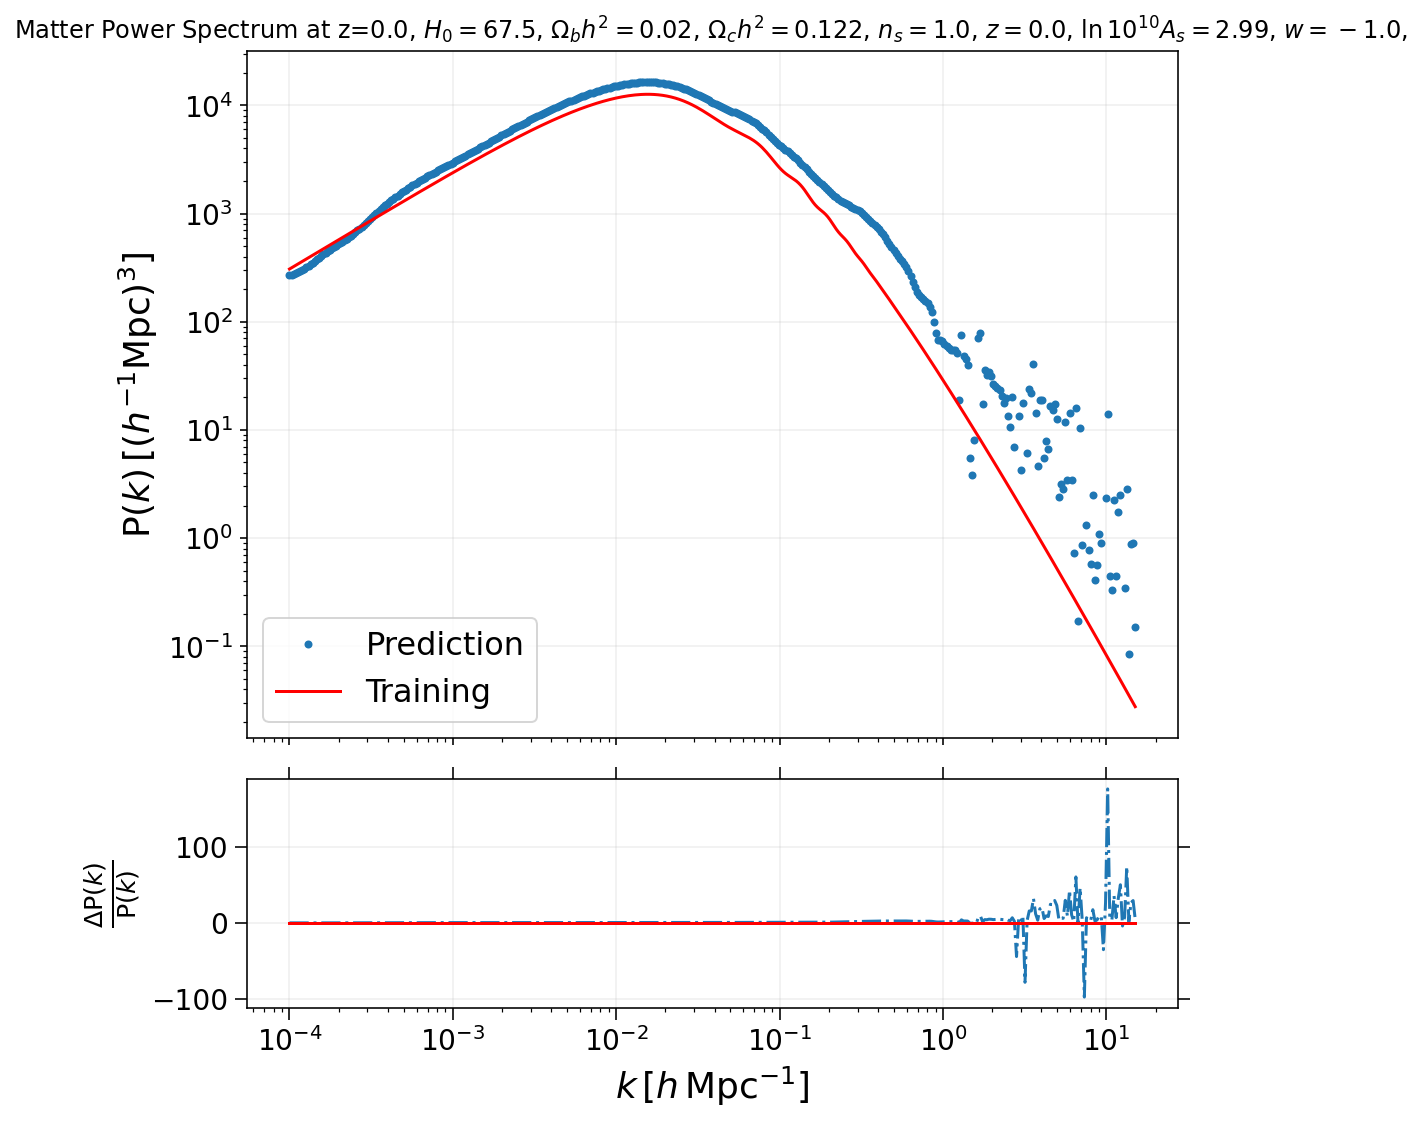

In [35]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 62.0 - 78.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250, ns: 0.88 - 1.06, z: 0.0 - 8.0, lnAs: 2.60 - 3.90, w: -1.5 - -0.6 ')
    print("\n")
    user_list = input_cosmo_val.split()
    print('parameters: ', user_list)

    # convert each item to int type
    for i in range(len(user_list)):
        # convert each item to int type
        user_list[i] = float(user_list[i])
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, 7))
    pred_pk = tf_model.predict(cosmo_arr)
    
    def camb_cosmo2():
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
        pars.InitPower.set_params(As = np.exp(cosmo_params[i,5])/(10**10), ns=cosmo_params[i,3])
        pars.set_matter_power(redshifts=[cosmo_params[i,4]], kmax=10.0)
        pars.set_dark_energy(w=cosmo_params[i,6], wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=400)
        s8 = np.array(results.get_sigma8())
    
        return camb_kh, camb_pk[0] 
    
    generate_camb_ps = camb_cosmo2()
#     temp = generate_camb_ps

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2], 'ns:', cosmo_arr[0][3], 'z:', cosmo_arr[0][4], 'lnAs:', cosmo_arr[0][5], 'w:', cosmo_arr[0][6])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,8), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(generate_camb_ps[0], pred_pk[0], "C0.")                                    
    #plt.loglog(X_test, y_test, "C1d")
    ax[0].loglog(generate_camb_ps[0], generate_camb_ps[1], 'r')                              
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$, ' %cosmo_arr[0][2] + '$n_{s} = %0.4s$, ' %cosmo_arr[0][3] + '$z = %0.4s$, ' %cosmo_arr[0][4] + '$\ln{10^{10}A_{s}} = %0.6s$, ' %cosmo_arr[0][5] + '$w = %0.6s$, ' %cosmo_arr[0][6],   fontsize = 12)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
#     #pred_pk needs to be sorted:
#     zipped_lists = zip(temp, pred_pk)
#     sorted_pairs = sorted(zipped_lists)

#     tuples = zip(*sorted_pairs)
#     temp, pred_pk = [list(tuple) for tuple in  tuples]
#     temp = np.array(temp)
#     pred_pk = np.array(pred_pk)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].loglog(generate_camb_ps[0], ((pred_pk[0]-generate_camb_ps[1])/generate_camb_ps[1]), 'C0', linestyle="dashdot") 
    ax[1].loglog(generate_camb_ps[0], ((generate_camb_ps[1]-generate_camb_ps[1])/generate_camb_ps[1]), 'r')
    ax[1].set_yscale('linear')
    fig.tight_layout()
    #plt.savefig('power_spectrum_H0.pdf')
    plt.show()
    
    

Generate = calc_cosmo()